In [32]:
import matplotlib.pyplot as plt
import estimation_methods as est
import numpy as np
from tqdm import tqdm

np.random.seed(1)

In [41]:
plt.rcParams["figure.figsize"] = (8, 8)

colors = {
    'deka': 'tab:blue',
    'deka_0': 'tab:blue',
    'deka_0.5': 'tab:cyan',
    'deka_0.9': 'tab:purple',
    'rls': 'tab:orange',
    'kf': 'tab:green',
    'rk': 'tab:brown',
    'true': 'black',
    'noise_region': 'red',
    'noise_bound': 'red'
}

names = {"gt": "True", "rk":"DeKA (-s, -g)", "deka": "DeKA (-s)", "deka_0.5": "DeKA (s=0.5)", "deka_0.9": "DeKA (s=0.9)"}

# Increase global font size
plt.rcParams.update({'font.size': 16})  # Adjust as needed for better readability

# Testing using synthetic systems

To compare our adaptive filters, we can generate synthetic systems that incorporate various types of perturbations and that feature varying levels of overdeterminedness. 

### Model setup

Consider an arbitrary multivariate signal and its measurement. We denote the system as:

$$\theta_{k+1}=f(x_k,u_k;\theta_k)+v_k$$

and the measurement as:

$$\hat{x}_{k+1}=h(x_k,u_k;\theta_{k})+w_k$$

where $\theta_k\in\mathbb{R}^n$, $x_k\in\mathbb{R}^m$, $v_k\sim\mathcal{N}(0, Q)$, and $w_k\sim\mathcal{N}(0, R)$. (Note: We use $\theta$ and $x$ because we are interested in parameter estimation whereas for state estimation you might use $x$ in the system and $y$ in the measurement.)

Then, we linearize the measurement model with respect to previous parameters $\hat{\theta}_{k-1}$ using a first-order approximation:

$$\hat{x}_{k+1}\approx f(x_k,u_k;\hat{\theta}_{k-1})+\left.\frac{\partial f}{\partial\theta}\right\vert_{\hat{\theta}_{k-1}}(\theta_k-\hat{\theta}_{k-1})+w_k$$

Then, if we let

$$A_k=\left.\frac{\partial f}{\partial\theta}\right\vert_{\hat{\theta}_{k-1}},\quad b_k=\hat{x}_{k+1}-f(x_k,u_k;\hat{\theta}_{k-1})+A_k\hat{\theta}_{k-1}-w_k$$

we can rewrite the linearized measurement form as:

$$A_k\theta_k=b_k.$$


### Adaptive filters

For RLS and DEKA adaptive filters, we can directly estimate the parameters given an initial estimate, the Jacobian of the measurement model with respect to the previous parameter estimate, and the actual measurement. For EKF, however, we must also consider the noise covariance matrices and system model Jacobian. As we do not know a priori what will occur to the system, we assume that the Jacobian of the system is:

$$F_k=\left.\frac{\partial f}{\partial\theta}\right\vert_{\hat{\theta}_{k-1}}=I_n.$$

Similarly, we assume that both system and measurement noise is time invariant. Thus:

$$Q_k=c_1I_n,\quad R_k=c_2I_m$$

for some $c_1\in\mathbb{R}^n$ and $c_2\in\mathbb{R}^m$. This reduces the predicted covariance update step in EKF to:

$$P_{k|k-1}=F_kP_{k-1|k-1}F_k^\mathsf{T}+Q_{k-1}=P_{k-1}+Q_{k-1}$$

For the remaining EKF steps, see the [Wikipedia page](https://en.wikipedia.org/wiki/Extended_Kalman_filter).


### Simulating on synthetic systems

We are interested in not only Gaussian noise but also arbitrary (sudden and gradual) scalings of the parameters. The latter case is of particular interest as we want to simulate how parameters may change in real-life scenarios like if a quadrotor were to pick up a large payload. Traditional adaptive filters should be able to handle these situations but they do not make use of particular inductive biases such as near-overdeterminedness of real-life systems.

To this end, we consider an arbitrary state space model:

$$\theta_{k+1}=\theta_k+v_k$$
$$\hat{x}_{k+1}=F_k\theta_k+w_k$$

## Ablation 1: RK vs DeKA (no smoothing) - low noise (compare average number of iterations)

deka: 2.9282049449753613e-07
rk: 7.438254501338213e-08
gt: 0


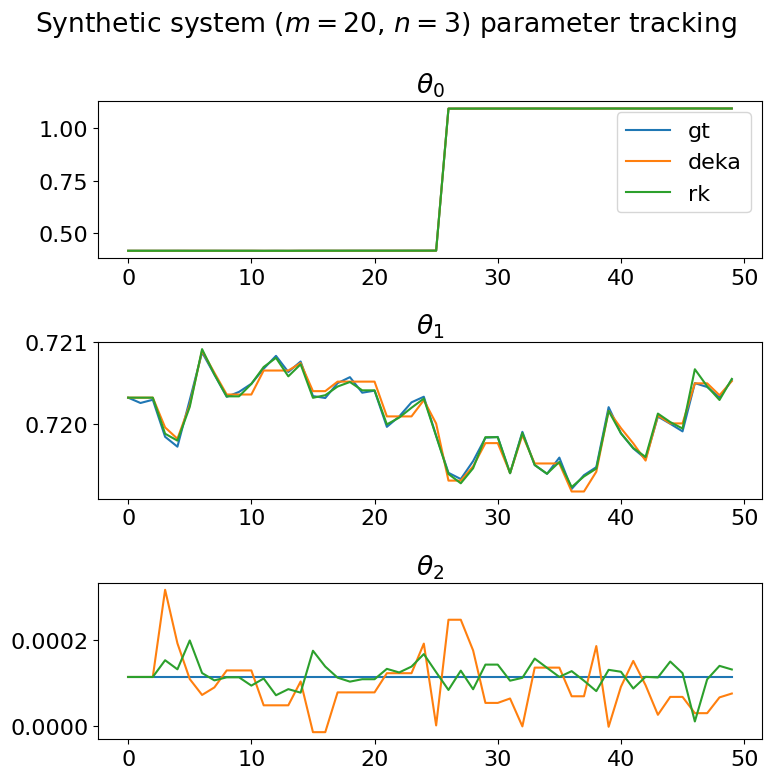

In [44]:
# simulation parameters
d = 20
p = 3

theta_true = np.random.rand(p, 1)
process_noise_var = (0.05 * theta_true / 2) ** 2

filters = {
    'deka': est.DEKA_tmp(p, x0=theta_true.copy(), damping=1, regularization=1e-6, smoothing_factor=0),
    'rk': est.RK(p, x0=theta_true.copy(), alpha=0.5),
}

estimates = {f: [[] for _ in range(p)] for f in filters.keys()}
iters = {f: [] for f in filters.keys()}
actual = []
mse = {f: [] for f in filters.keys()}

# simulate system
nsim = 50

for k in range(nsim):
    A_k = np.random.randn(d, p)
    b_k = A_k @ theta_true

    measurement_noise_var = (0.01 * b_k / 2) ** 2
    b_k += np.array([np.random.normal(0, v) for v in measurement_noise_var]).reshape(-1, 1)

    for name, f in filters.items():
        if 'deka' in name:
            estimate, _, it = f.iterate(A_k, b_k, num_iterations=int(d ** 2 / p), tol=1e-3)
            iters[name].append(it)
        elif 'rk' in name:
            estimate, it = f.iterate(A_k, b_k, num_iterations=int(d ** 2 / p), tol=1e-3)
            iters[name].append(it)
        else:
            estimate = f.iterate(A_k, b_k)

        for i in range(p):
            estimates[name][i].append(estimate[i].item())
        
        mse[name].append(np.square(estimate - theta_true).mean())

    actual.append(theta_true.copy())

    # add perturbation
    theta_true += np.array([np.random.normal(0, v) for v in process_noise_var])

    # add major perturbation to parameter 0 only
    if k == 25:
        theta_true[0] *= np.random.uniform(0.25, 4)

# process data
mse['gt'] = [0 for _ in range(nsim)]
actual = np.array(actual).squeeze().T

# print total mse
for name, vals in mse.items():
    print(f"{name}: {np.sum(vals)}")

# plot results
nplots = p
fig, axs = plt.subplots(nplots)

fig.suptitle(f"Synthetic system ($m={d}$, $n={p}$) parameter tracking")

for i in range(nplots):
    axs[i].plot(actual[i], label="gt")
    # axs[i].set_yscale("log")
    axs[i].set_title(f"$\\theta_{i}$")

for name, vals in estimates.items(): 
    for i in range(nplots):
        axs[i].plot(vals[i], label=name)

axs[0].legend()

fig.tight_layout()
plt.show()

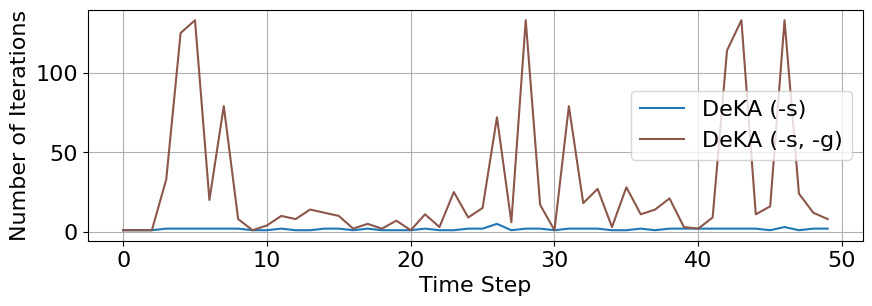

In [45]:
fig, ax = plt.subplots(figsize=(10, 3))

for name, it in iters.items():
    ax.plot(it, label=names[name], color=colors[name])

ax.set_xlabel("Time Step")
ax.set_ylabel("Number of Iterations")
ax.legend()
ax.grid(True)
plt.show()

In [29]:
d = 20
p = 3

nsim = 50
trials = 1000

filter_names = [
    'deka_0',
    'rk'
]

mse = {f: [] for f in filter_names}
non_pert_mse = {f: [] for f in filter_names}

# For each filter, create a list of lists (one list per timestep) to store iteration counts.
iteration_counts = {f: [[] for _ in range(nsim)] for f in filter_names}

for t in tqdm(range(trials)):
    theta_true = np.random.rand(p, 1)
    process_noise_var = (0.05 * theta_true / 2) ** 2

    filters = {
        'deka_0': est.DEKA_tmp(p, x0=theta_true.copy(), damping=1, regularization=1e-6, smoothing_factor=0),
        'rk': est.RK(p, x0=theta_true.copy(), alpha=0.5),
    }

    trial_mse = {f: [] for f in filters}
    trial_non_pert_mse = {f: [] for f in filters}

    for k in range(nsim):
        A_k = np.random.randn(d, p)  # Random Jacobian (linear transformation)
        b_k = A_k @ theta_true

        # Add measurement noise: roughly [0, 1]% noise with 95% probability
        measurement_noise_var = (0.01 * b_k / 2) ** 2
        b_k += np.array([np.random.normal(0, v) for v in measurement_noise_var]).reshape(-1, 1)

        for name, f in filters.items():
            if 'deka' in name:
                estimate, _, it = f.iterate(A_k, b_k, num_iterations=int(d ** 2 / p), tol=1e-3)
            elif 'rk' in name:
                estimate, it = f.iterate(A_k, b_k, num_iterations=int(d ** 2 / p), tol=1e-3)
            else:
                estimate = f.iterate(A_k, b_k)
                it = None  # In case no iteration count is returned
            
            # Append the iteration count for the current timestep k
            iteration_counts[name][k].append(it)

            # Calculate mean squared error for this timestep
            sq_res = np.square(estimate - theta_true)
            trial_mse[name].append(sq_res.mean())
            trial_non_pert_mse[name].append(sq_res[1:].mean())

        # Update theta_true by adding process noise
        theta_true += np.array([np.random.normal(0, v) for v in process_noise_var])

        # Add a major perturbation to parameter 0 at timestep 25
        if k == 25:
            theta_true[0] *= np.random.uniform(0.25, 4)
    
    for name, vals in trial_mse.items():
        mse[name].append(np.sum(vals))
    
    for name, vals in trial_non_pert_mse.items():
        non_pert_mse[name].append(np.sum(vals))

# Compute the average iteration count per timestep for each filter
avg_iter_counts = {}
for name in filter_names:
    # For each timestep, compute the mean iteration count across all trials
    avg_iter_counts[name] = np.array([np.mean(iteration_counts[name][k]) for k in range(nsim)])

100%|██████████| 1000/1000 [01:50<00:00,  9.02it/s]


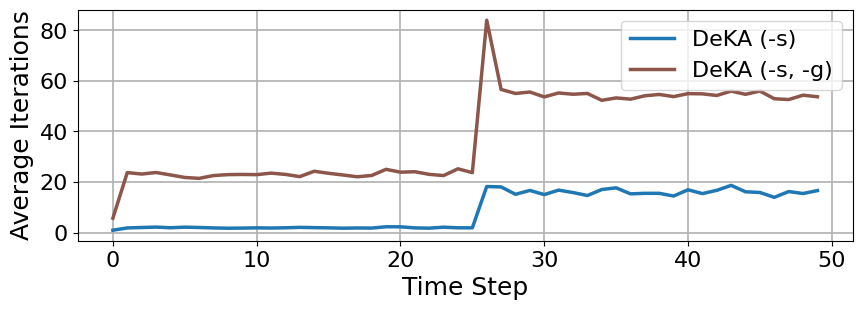

In [47]:
fig, ax = plt.subplots(figsize=(10, 3))
timesteps = np.arange(nsim)

for key, it in avg_iter_counts.items():
    short_key = 'deka' if 'deka' in key else key

    # Compute standard deviation for shading
    std_vals = np.std(iteration_counts[key], axis=1)
    lower_bound = np.maximum(0, it - std_vals)  # Ensure lower bound is ≥ 0
    upper_bound = it + std_vals

    # Plot mean with thicker lines
    ax.plot(timesteps, it, label=names[short_key], color=colors[short_key], linewidth=2.5)
    # ax.fill_between(timesteps, lower_bound, upper_bound, color=colors[short_key], alpha=0.3)

# Larger labels and legend
ax.set_xlabel("Time Step", fontsize=18)
ax.set_ylabel("Average Iterations", fontsize=18)
ax.legend(fontsize=16)
ax.grid(True, linewidth=1.2)  # More visible gridlines

# Increase tick size
ax.tick_params(axis='both', which='major', labelsize=16)

plt.show()

Parameter tracking MSE averages
deka_0: 5.907497269497442e-07
rk: 0.0007808431644270105
Non-perturbed parameter tracking MSE averages
deka_0: 5.130553404801001e-07
rk: 0.0004945793871334467
Iteration counts summary:
deka_0: avg iterations per update = 8.77232, std deviation = 29.01803924832965, total iterations = 438616


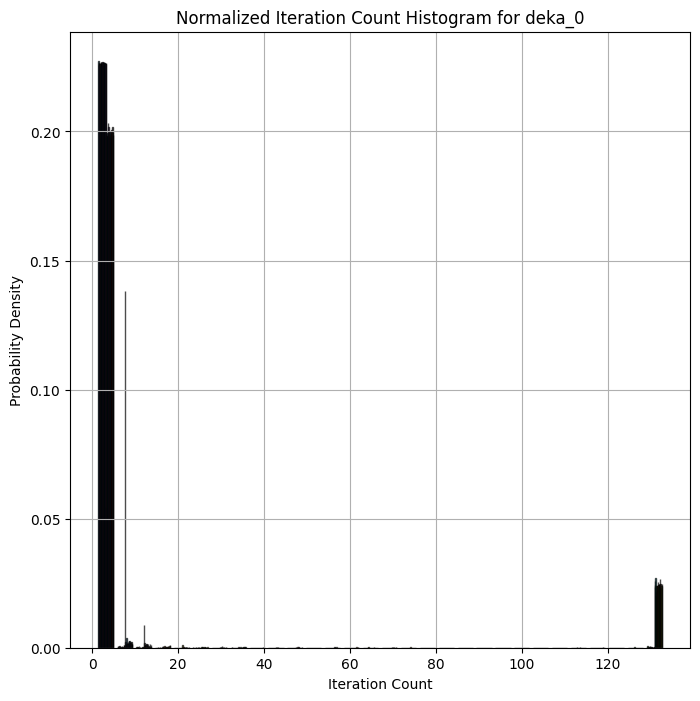

rk: avg iterations per update = 38.28152, std deviation = 49.26414016797207, total iterations = 1914076


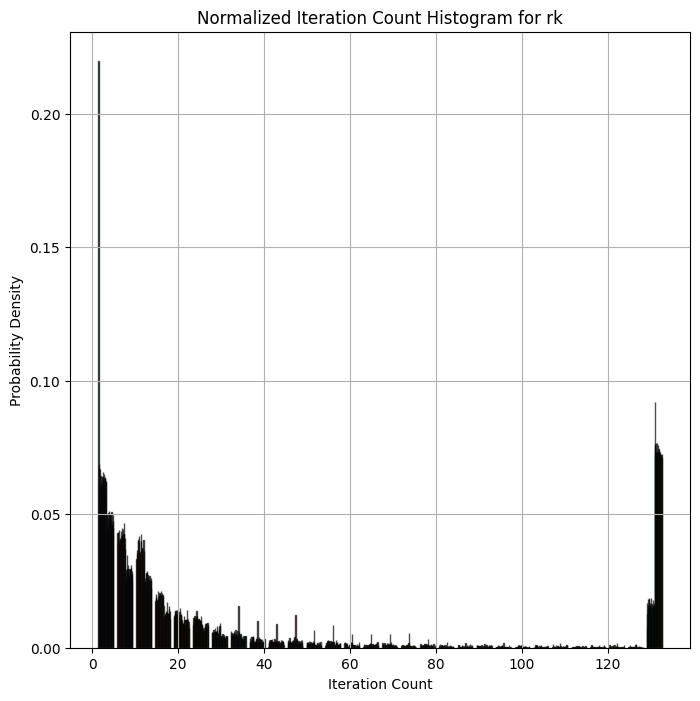

In [13]:
print("Parameter tracking MSE averages")
for name, vals in mse.items():
    print(f"{name}: {np.mean(vals)}")

print("Non-perturbed parameter tracking MSE averages")
for name, vals in non_pert_mse.items():
    print(f"{name}: {np.mean(vals)}")

print("Iteration counts summary:")
for name, iters in iteration_counts.items():
    avg_iters = np.mean(iters)
    std_iters = np.std(iters)
    total_iters = np.sum(iters)
    print(f"{name}: avg iterations per update = {avg_iters}, std deviation = {std_iters}, total iterations = {total_iters}")

    plt.figure()
    plt.hist(iters, bins=30, density=True, alpha=0.7, edgecolor='black')
    plt.title(f"Normalized Iteration Count Histogram for {name}")
    plt.xlabel("Iteration Count")
    plt.ylabel("Probability Density")
    plt.grid(True)
    plt.show()

## Ablation 2: GRK vs DeKA (smoothing) - high noise (compare MSE)

deka_0: 0.1711748007372756
deka_0.5: 0.053380824583448956
deka_0.9: 0.0724491872275859
gt: 0


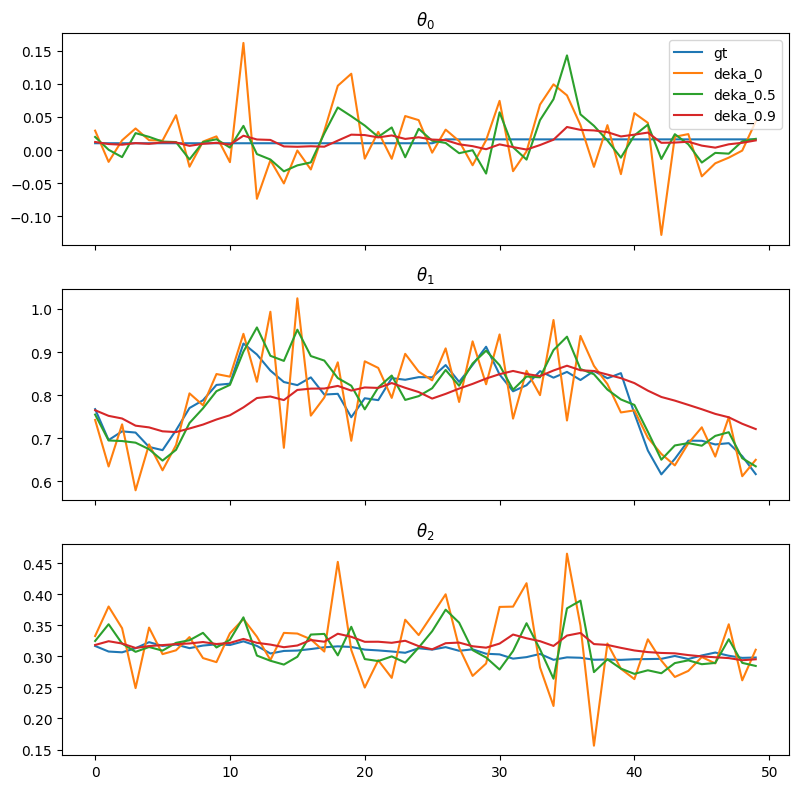

In [14]:
# simulation parameters
d = 20
p = 3

theta_true = np.random.rand(p, 1)
process_noise_var = (0.5 * theta_true / 2) ** 2

filters = {
    'deka_0': est.DEKA_tmp(p, x0=theta_true.copy(), damping=1, regularization=1e-6, smoothing_factor=0),
    'deka_0.5': est.DEKA_tmp(p, x0=theta_true.copy(), damping=1, regularization=1e-6, smoothing_factor=0.5),
    'deka_0.9': est.DEKA_tmp(p, x0=theta_true.copy(), damping=1, regularization=1e-6, smoothing_factor=0.9),
}

estimates = {f: [[] for _ in range(p)] for f in filters.keys()}
actual = []
mse = {f: [] for f in filters.keys()}

# simulate system
nsim = 50

for k in range(nsim):
    A_k = np.random.randn(d, p)  # random Jacobian (or basically linear transformation)
    b_k = A_k @ theta_true

    # noise is [0 - 1]% noise w.p. 95%
    measurement_noise_var = (0.5 * b_k / 2) ** 2
    b_k += np.array([np.random.normal(0, v) for v in measurement_noise_var]).reshape(-1, 1)

    for name, f in filters.items():
        if 'deka' in name:
            estimate, _, it = f.iterate(A_k, b_k, num_iterations=int(d ** 2 / p), tol=1e-3)
        elif 'rk' in name:
            estimate, it = f.iterate(A_k, b_k, num_iterations=int(d ** 2 / p), tol=1e-3)
        else:
            estimate = f.iterate(A_k, b_k)

        for i in range(p):
            estimates[name][i].append(estimate[i].item())
        
        mse[name].append(np.square(estimate - theta_true).mean())

    actual.append(theta_true.copy())

    # add perturbation
    theta_true += np.array([np.random.normal(0, v) for v in process_noise_var])

    # add major perturbation to parameter 0 only
    if k == 25:
        theta_true[0] *= np.random.uniform(0.25, 4)

# process data
mse['gt'] = [0 for _ in range(nsim)]
actual = np.array(actual).squeeze().T

# print total mse
for name, vals in mse.items():
    print(f"{name}: {np.sum(vals)}")

# plot results
nplots = p
fig, axs = plt.subplots(nplots, sharex=True)

for i in range(nplots):
    axs[i].plot(actual[i], label="gt")
    # axs[i].set_yscale("log")
    axs[i].set_title(f"$\\theta_{i}$")

for name, vals in estimates.items(): 
    for i in range(nplots):
        axs[i].plot(vals[i], label=name)

# for name, it in iters.items():
#     axs[nplots].plot(it, label=name)

axs[0].legend()
# axs[nplots].legend()

fig.tight_layout()
plt.show()

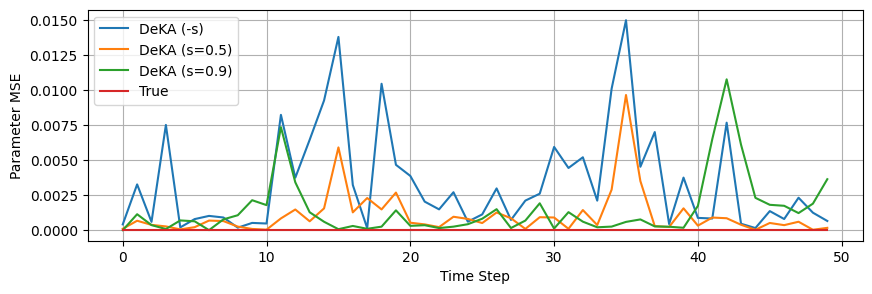

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))


for name, it in mse.items():
    ax.plot(it, label=names[name])#, color=colors[name])

# ax.set_title("")
ax.set_xlabel("Time Step")
ax.set_ylabel("Parameter MSE")
ax.legend()
ax.grid(True)
plt.show()

In [50]:
from joblib import Parallel, delayed

# Simulation parameters
d = 20
p = 3
nsim = 50
trials = 1000

# Define filter names
filter_names = ['deka_0', 'deka_0.5', 'deka_0.9']

def run_trial():
    
    theta_true = np.random.rand(p, 1)
    process_noise_var = (0.5 * theta_true / 2) ** 2

    filters = {
        'deka_0': est.DEKA_tmp(p, x0=theta_true.copy(), damping=0.1, regularization=1e-6, smoothing_factor=0),
        'deka_0.5': est.DEKA_tmp(p, x0=theta_true.copy(), damping=0.1, regularization=1e-6, smoothing_factor=0.5),
        'deka_0.9': est.DEKA_tmp(p, x0=theta_true.copy(), damping=0.1, regularization=1e-6, smoothing_factor=0.9),
    }
    
    trial_mse = {f: [] for f in filters}
    
    for k in range(nsim):
        A_k = np.random.randn(d, p)  # random Jacobian (linear transformation)
        b_k = A_k @ theta_true
        
        # Add measurement noise: roughly [0, 1]% noise (95% chance)
        measurement_noise_var = (0.5 * b_k / 2) ** 2
        b_k += np.array([np.random.normal(0, v) for v in measurement_noise_var]).reshape(-1, 1)
        
        for name, f in filters.items():
            # For DEKA filters, call iterate to get the estimate
            if 'deka' in name:
                estimate, _, _ = f.iterate(A_k, b_k, num_iterations=int(d ** 2 / p), tol=1e-3)
            else:
                estimate = f.iterate(A_k, b_k)
            
            # Compute mean squared error (MSE)
            mse_val = np.square(estimate - theta_true).mean()
            trial_mse[name].append(mse_val)
        
        # Update theta_true with process noise
        theta_true += np.array([np.random.normal(0, v) for v in process_noise_var])
        # Add a major perturbation to parameter 0 at timestep 25
        if k == 25:
            theta_true[0] *= np.random.uniform(0.25, 4)
    
    return trial_mse  # Each filter's MSE over nsim timesteps

# Run trials in parallel
results = Parallel(n_jobs=-1)(delayed(run_trial)() for _ in tqdm(range(trials)))

# Organize results: for each filter, create a list of MSE arrays from each trial.
mse_by_timestep = {f: [] for f in filter_names}
for trial_result in results:
    for name in filter_names:
        mse_by_timestep[name].append(trial_result[name])

# Convert lists to arrays and compute the mean and standard deviation over trials
avg_mse_vs_timestep = {}
std_mse_vs_timestep = {}
for name in filter_names:
    data = np.array(mse_by_timestep[name])  # shape: (trials, nsim)
    avg_mse_vs_timestep[name] = data.mean(axis=0)
    std_mse_vs_timestep[name] = data.std(axis=0)

100%|██████████| 1000/1000 [01:42<00:00,  9.72it/s]


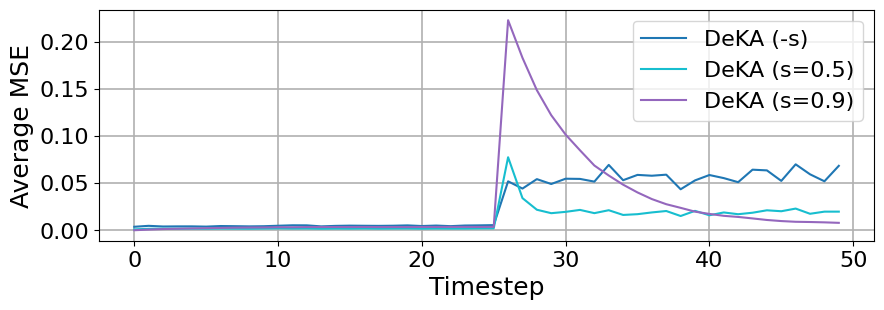

In [51]:
names_mapping = {
    'deka_0': 'DeKA (-s)',
    'deka_0.5': 'DeKA (s=0.5)',
    'deka_0.9': 'DeKA (s=0.9)'
}

# Plot the average MSE vs timestep with shaded ±1 standard deviation region
fig, ax = plt.subplots(figsize=(10, 3))
timesteps = np.arange(nsim)

for name in filter_names:
    avg_vals = avg_mse_vs_timestep[name]
    std_vals = std_mse_vs_timestep[name]

    # Ensure lower bound is at least 0
    lower_bound = np.maximum(0, avg_vals - std_vals)
    upper_bound = avg_vals + std_vals

    ax.plot(timesteps, avg_vals, label=names_mapping[name], color=colors[name])
    # ax.fill_between(timesteps, lower_bound, upper_bound, color=colors[name], alpha=0.3)

# Larger labels and legend
ax.set_xlabel("Timestep", fontsize=18)
ax.set_ylabel("Average MSE", fontsize=18)
ax.legend(fontsize=16)
ax.grid(True, linewidth=1.2)  # Make gridlines more visible

# Increase tick size
ax.tick_params(axis='both', which='major', labelsize=16)

plt.show()

In [18]:
print("Parameter tracking MSE averages")
for name, vals in mse.items():
    print(f"{name}: {np.mean(vals)}")

print("Non-perturbed parameter tracking MSE averages")
for name, vals in non_pert_mse.items():
    print(f"{name}: {np.mean(vals)}")

Parameter tracking MSE averages
deka_0: 0.003423496014745512
deka_0.5: 0.0010676164916689791
deka_0.9: 0.001448983744551718
gt: 0.0
Non-perturbed parameter tracking MSE averages
deka_0: 5.130553404801001e-07
rk: 0.0004945793871334467
